In [1]:
from src.sindy_rl_functions import *
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Polygon
import numpy as np
import pandas as pd
import json
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Step 1: Rescorla-Wagner Functions
The following functions can be used for different R-W delta updating rules. Currently there are two: `standard_RW` is a stardard approach where expected value is updated according to a scaled reward-prediction error. `classic_RW` is more true to the original Rescorla-Wagner model, which assumes a total ceiling of expected value shared across bandits; this classic approach can be used to simulate blocking effects.

In [2]:
def standard_RW(r, Q, c, eta):
    delta = r - Q[c]
    Q[c] = Q[c] + eta * delta
    return Q

def classic_RW(r, Q, c, eta):
    if (sum(Q) >= 1 and r == 1) or (sum(Q) <= 0 and r == 0):
        pass
    else:
        delta = r - sum(Q)
        Q_learned = eta * delta
        Q[c] = Q[c] + Q_learned
    return Q

## Step 2: Updating Functions
The following functions can be used for determining your learning-rate $\eta$ at each timepoint $t$. `learning_fixed` is a standard updating rate where $\eta$ is static across trials. `learning_decay` exponentiates $\eta$ with time, such that $\eta$ will decay with time when parameter $d$ is negative, and grow with time when $d$ is positive. Finally, `learning_asym_fixed` is an asymmetric version of the standard updating function where $\eta$ is dynamic with reward, such that there are separate learning rates for positive and negative reward prediction errors.

In [3]:
def learning_fixed(pars, t, r):
    a = pars[0]
    # where a is the fixed learning-rate
    return a

def learning_decay(pars, t, r):
    d = pars[0]
    # where d is the strength of learning-rate decay over time. should be negative for decay.
    return np.exp(-t/d)

def learning_asym_fixed(pars, t, r):
    if r == 1:
        a = pars[0] # where a is a fixed learning rate associated with reward
    elif r == 0:
        a = pars[1] # where a is a fixed learning rate associated with punishment
    return a

## Part 3: Simulate participants and train SINDy with simulated data. 
See the rl_simulation_controlled_variables_Nsubjects.ipynb for functions for:
1. Generating data and the training set (preSINDYsim())
2. Defining the feature library (SINDYlibrary())
3. Training/fitting the SINDy model to the data (SINDYfit())
4. Simulating a final participant as a testing set and using the trained SINDy model to attempt to simulate that testing participant. Plot the outcome. (SINDYsim())

First, we'll simulate and fit data using a fixed learning rate of 0.2 (learning_fixed([0.2], t, r))

(qvals[0])[k+1] = 0.800 qvals[0][k] + 0.200 rewards[k]
R^2 = 0.9999999974536834


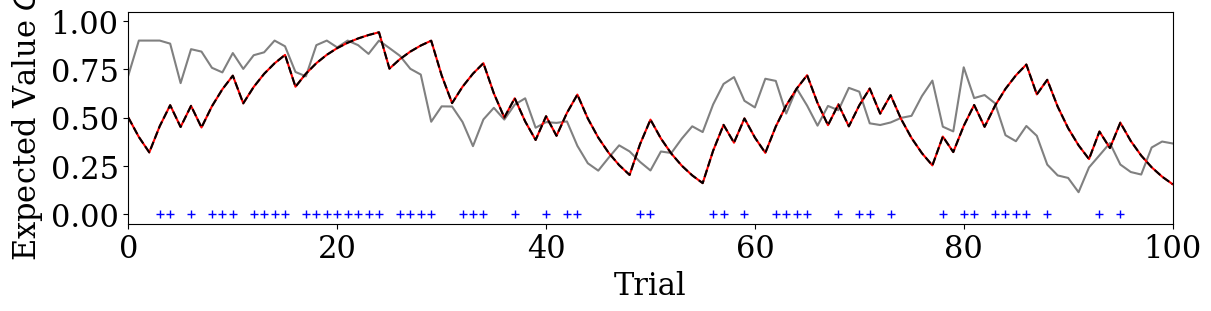

0.9999999974536834

In [4]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (20, 10)

RLparams = {'subs': 100, # number of subjects for training data
               'T': 100, # number of trials per subject
               'RW_function': standard_RW, # Rescoral-Wagner function
               'q_noise': 0, # SD of 0-centered normal around which to sample noise to perterb each Q
               'eta_function': learning_fixed, # learning rate function
               'eta_params': [.2], # parameters for learning rate function
               'eta_noise': 0, #SD of 0-centered normal around which to sample noise to perterb each trial's learning rate(s)
               'beta_params': 1, # parameters for inverse temperature parameter of softmax (currently just fixed value)
               'bandits': 1, # keep at 1 for now
               'mu0': 0.5, # initial true qval
               'mu_behavior': 'random_walk_varying_intercept', # behavior of true qval (see the Reward Functions in rl_simulation_controlled_variables_Nsubjects)
               'reversal': None, # trial at which to reverse reward probabilities - set to None for no reversal
               'seed': 103, # seed starting value - increases by 1 for each subject
               }

qvals, qvalslist, X_test, control_inputs_training, control_inputs_testing, truevalslist, C, L = preSINDYsim(RLparams)

generalized_library, feat_names = SINDYlibrary(qvals, 1, False)
model, t, r2 = SINDYfit(generalized_library, feat_names, qvalslist, X_test, control_inputs_training, control_inputs_testing, RLparams, 0.9)
model.print()
print('R^2 = %s' % r2)

SINDYsim(model, X_test, control_inputs_testing, truevalslist, C, L, RLparams, r2)

Next, we'll simulate and fit data using a learning rate with time-dependent decay rate of 10 (learning_decay([10], t, r))

(qvals[0])[k+1] = 1.000 qvals[0][k] + -1.104 qvals[0][k] exp(-time[k]/10) + 1.104 rewards[k] exp(-time[k]/10)
R^2 = 0.9999993504425972


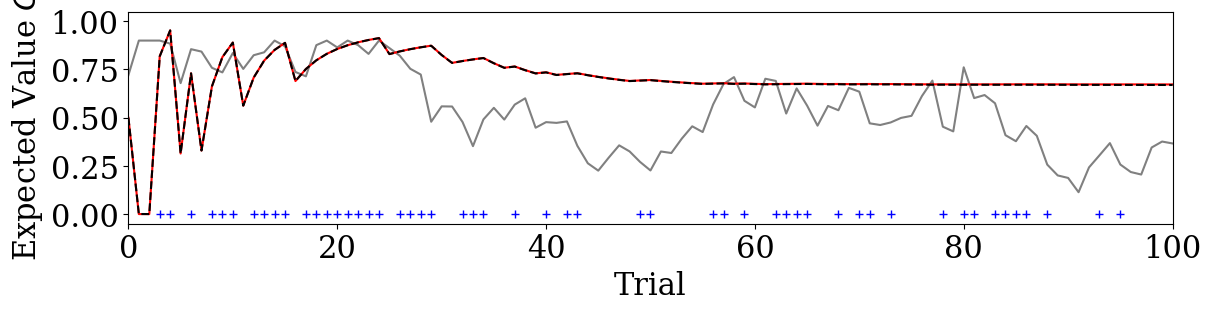

0.9999993504425972

In [5]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (20, 10)

RLparams = {'subs': 100, # number of subjects for training data
               'T': 100, # number of trials per subject
               'RW_function': standard_RW, # Rescoral-Wagner function
               'q_noise': 0, # SD of 0-centered normal around which to sample noise to perterb each Q
               'eta_function': learning_decay, # learning rate function
               'eta_params': [10], # parameters for learning rate function
               'eta_noise': 0, #SD of 0-centered normal around which to sample noise to perterb each trial's learning rate(s)
               'beta_params': 1, # parameters for inverse temperature parameter of softmax (currently just fixed value)
               'bandits': 1, # keep at 1 for now
               'mu0': 0.5, # initial true qval
               'mu_behavior': 'random_walk_varying_intercept', # behavior of true qval (see the Reward Functions in rl_simulation_controlled_variables_Nsubjects)
               'reversal': None, # trial at which to reverse reward probabilities - set to None for no reversal
               'seed': 103, # seed starting value - increases by 1 for each subject
               }

qvals, qvalslist, X_test, control_inputs_training, control_inputs_testing, truevalslist, C, L = preSINDYsim(RLparams)

generalized_library, feat_names = SINDYlibrary(qvals, 1)
model, t, r2 = SINDYfit(generalized_library, feat_names, qvalslist, X_test, control_inputs_training, control_inputs_testing, RLparams, 0.9)
model.print()
print('R^2 = %s' % r2)

SINDYsim(model, X_test, control_inputs_testing, truevalslist, C, L, RLparams, r2)

Finally, we'll simulate and fit data using a asymmetic learning rates of 0.8 for positive RPEs and 0.2 for negative RPEs (learning_asym_fixed([0.8, 0.2], t, r))

(qvals[0])[k+1] = 0.800 qvals[0][k] + 0.800 rewards[k] + -0.600 qvals[0][k]*rewards[k]
R^2 = 0.999999967206427


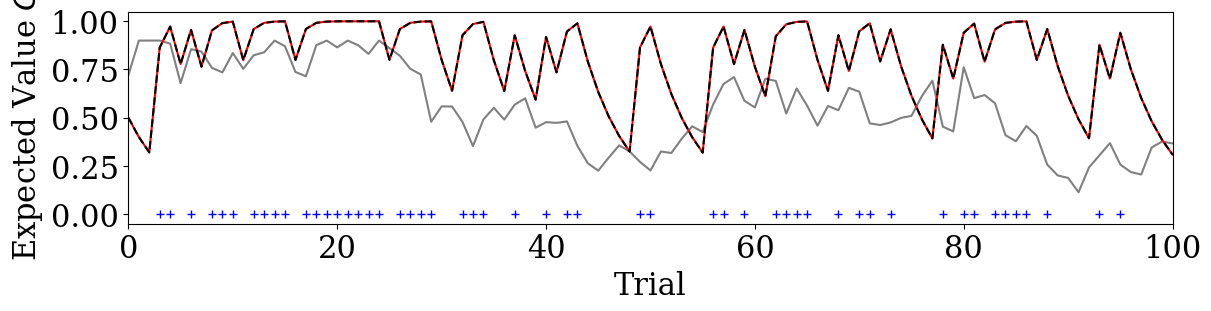

0.999999967206427

In [6]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (20, 10)

RLparams = {'subs': 100, # number of subjects for training data
               'T': 100, # number of trials per subject
               'RW_function': standard_RW, # Rescoral-Wagner function
               'q_noise': 0, # SD of 0-centered normal around which to sample noise to perterb each Q
               'eta_function': learning_asym_fixed, # learning rate function
               'eta_params': [0.8, 0.2], # parameters for learning rate function
               'eta_noise': 0, #SD of 0-centered normal around which to sample noise to perterb each trial's learning rate(s)
               'beta_params': 1, # parameters for inverse temperature parameter of softmax (currently just fixed value)
               'bandits': 1, # keep at 1 for now
               'mu0': 0.5, # initial true qval
               'mu_behavior': 'random_walk_varying_intercept', # behavior of true qval (see the Reward Functions in rl_simulation_controlled_variables_Nsubjects)
               'reversal': None, # trial at which to reverse reward probabilities - set to None for no reversal
               'seed': 103, # seed starting value - increases by 1 for each subject
               }

qvals, qvalslist, X_test, control_inputs_training, control_inputs_testing, truevalslist, C, L = preSINDYsim(RLparams)

generalized_library, feat_names = SINDYlibrary(qvals, 1)
model, t, r2 = SINDYfit(generalized_library, feat_names, qvalslist, X_test, control_inputs_training, control_inputs_testing, RLparams, 0.9)
model.print()
print('R^2 = %s' % r2)

SINDYsim(model, X_test, control_inputs_testing, truevalslist, C, L, RLparams, r2)

## Step 4: Assess model recovery as a function of initial conditions
We're prepared jsons of 1000 simulations each for each of the three learning models. As mentioned in the main text, learning/decay rates and sampled from the following distributions:

learning_fixed(): U(0, 1)
learning_decay(): U(5, 50)
learning_asym_fixed() : U(0, 1) for both rates

Jsons are dictionaries containing a list of fit statistics ('r2'), a list of rates ('eta', or 'eta1' and 'eta2' in the asymmetric case), and a list of recovered models ('eq'). The first element of each list corresponds with the first simulation, the second element with the second simulation, and so on

In [7]:
with open("simdata/learning_fixed.json", "r") as outfile:
    learning_fixed_simdata = json.load(outfile)

with open("simdata/learning_decay.json", "r") as outfile:
    learning_decay_simdata = json.load(outfile)

with open("simdata/learning_asym_fixed.json", "r") as outfile:
    learning_asym_fixed_simdata = json.load(outfile)

C:\Users\kjl113\AppData\Local\Temp\ipykernel_15884\3462183989.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='eta', y='r2', data=bindf, width=1, palette=bincolors)


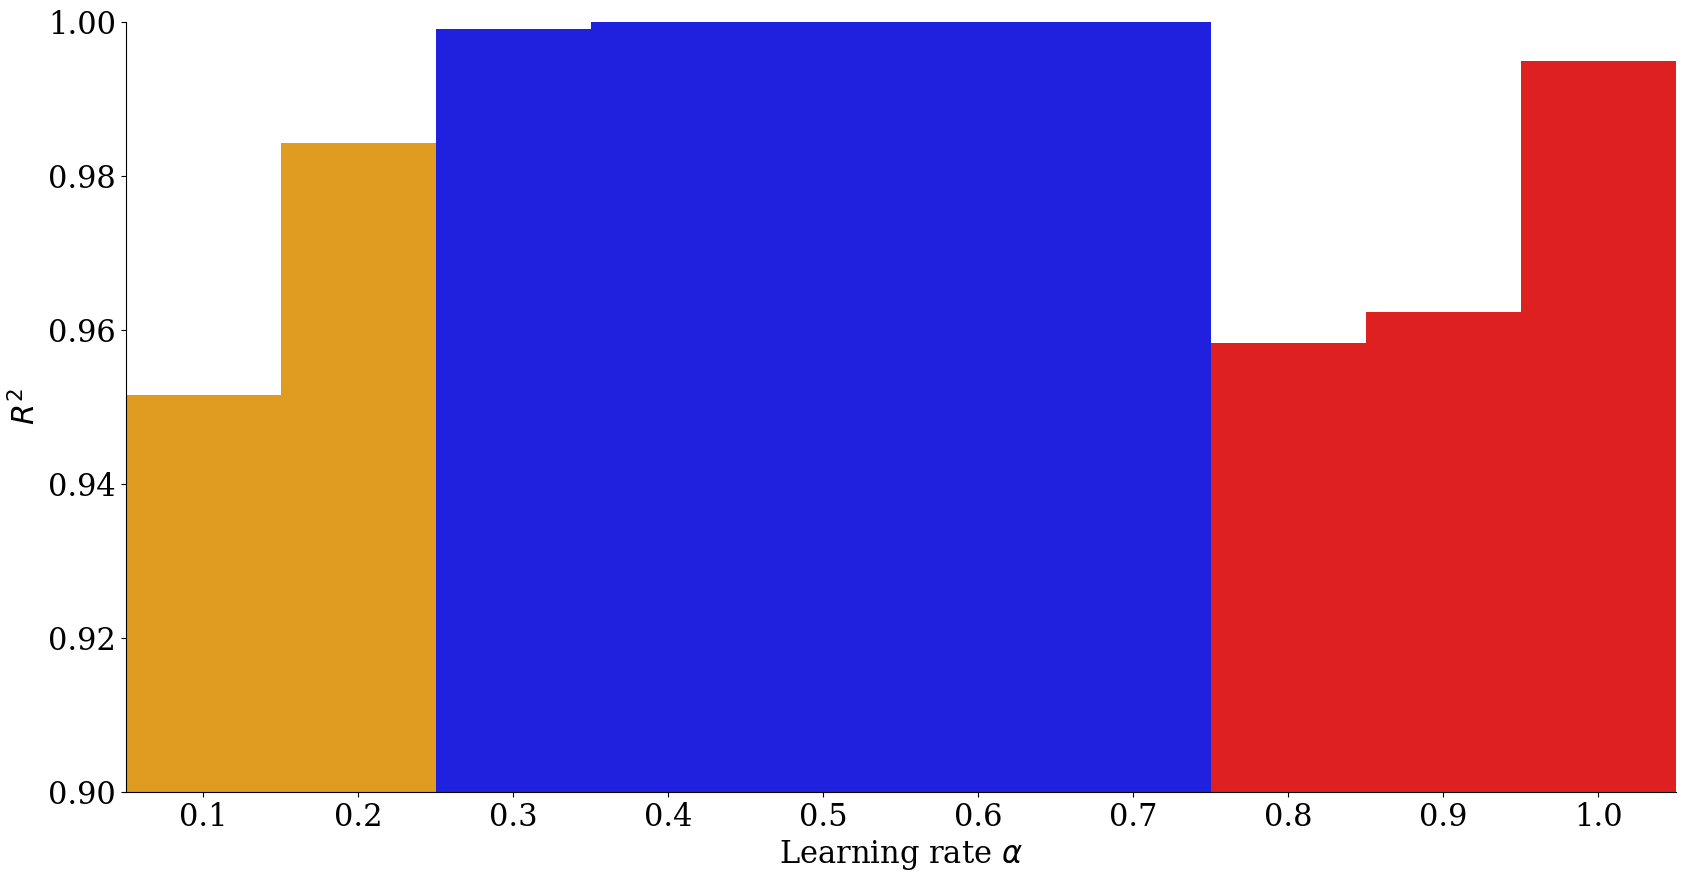

0.9999999986181115
0.909631845335738
0.999999999852338


In [8]:
data = pd.DataFrame(learning_fixed_simdata)
nbins=10
bincolors = ['orange', 'orange', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'red']
# bincolors = ['red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']
_, bins = pd.cut(data['eta'], bins=nbins, retbins=True, right=False)
# regroup your data by computed bins indexes
binned_data = data['r2'].groupby(np.digitize(data['eta'], bins)).mean()
eta_list = [round(50/nbins*i,1) for i in range(1,nbins+1)]
eta_list = [round(1/nbins*i,1) for i in range(1,nbins+1)]
bindf = {'eta': eta_list, 'r2': binned_data}
sns.barplot(x='eta', y='r2', data=bindf, width=1, palette=bincolors)
plt.ylabel(r'$R^2$')
plt.xlabel(r'Learning rate $\alpha$')
plt.ylim(.9,1)
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# plt.xlabel(r"$R^2$")
plt.show()
print(np.median(data['r2']))
print(np.percentile(data['r2'], 2.5))
print(np.percentile(data['r2'], 97.5))

C:\Users\kjl113\AppData\Local\Temp\ipykernel_15884\58304643.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='eta', y='r2', data=bindf, width=1, palette=bincolors)


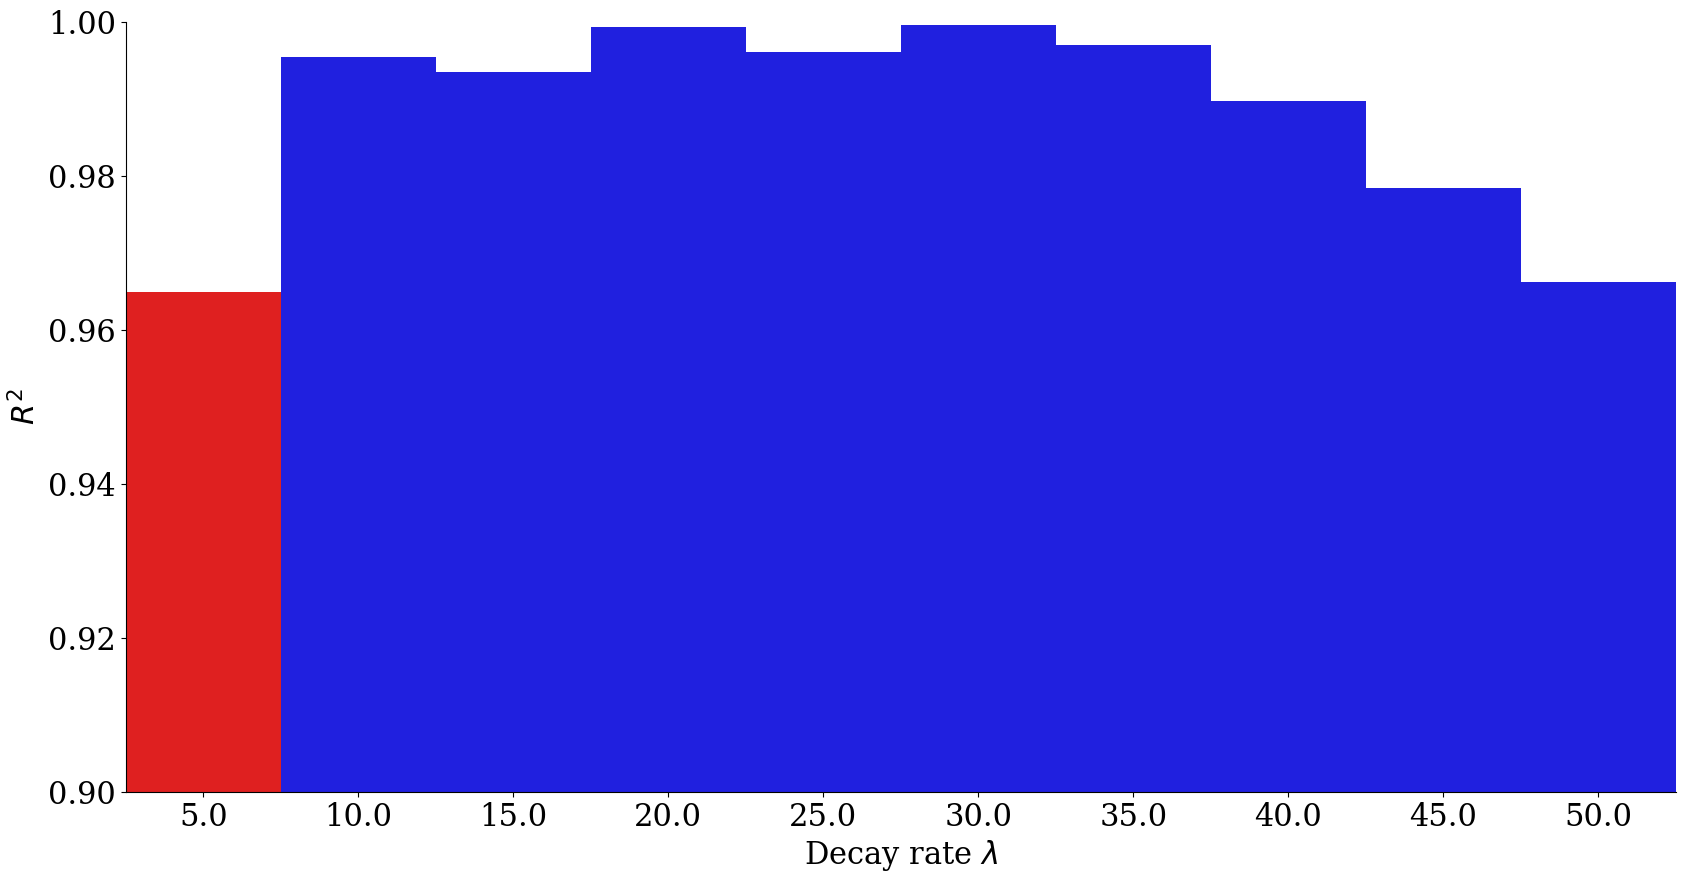

0.9949827865812275
0.9362699325681714
0.9999876914567166


In [9]:
data = pd.DataFrame(learning_decay_simdata)
nbins=10
bincolors = ['red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']
# bincolors = ['red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']
_, bins = pd.cut(data['eta'], bins=nbins, retbins=True, right=False)
# regroup your data by computed bins indexes
binned_data = data['r2'].groupby(np.digitize(data['eta'], bins)).mean()
eta_list = [round(50/nbins*i,1) for i in range(1,nbins+1)]
# eta_list = [round(1/nbins*i,1) for i in range(1,nbins+1)]
bindf = {'eta': eta_list, 'r2': binned_data}
sns.barplot(x='eta', y='r2', data=bindf, width=1, palette=bincolors)
plt.ylabel(r'$R^2$')
plt.xlabel(r'Decay rate $\lambda$')
plt.ylim(.9,1)
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# plt.xlabel(r"$R^2$")
plt.show()
print(np.median(data['r2']))
print(np.percentile(data['r2'], 2.5))
print(np.percentile(data['r2'], 97.5))

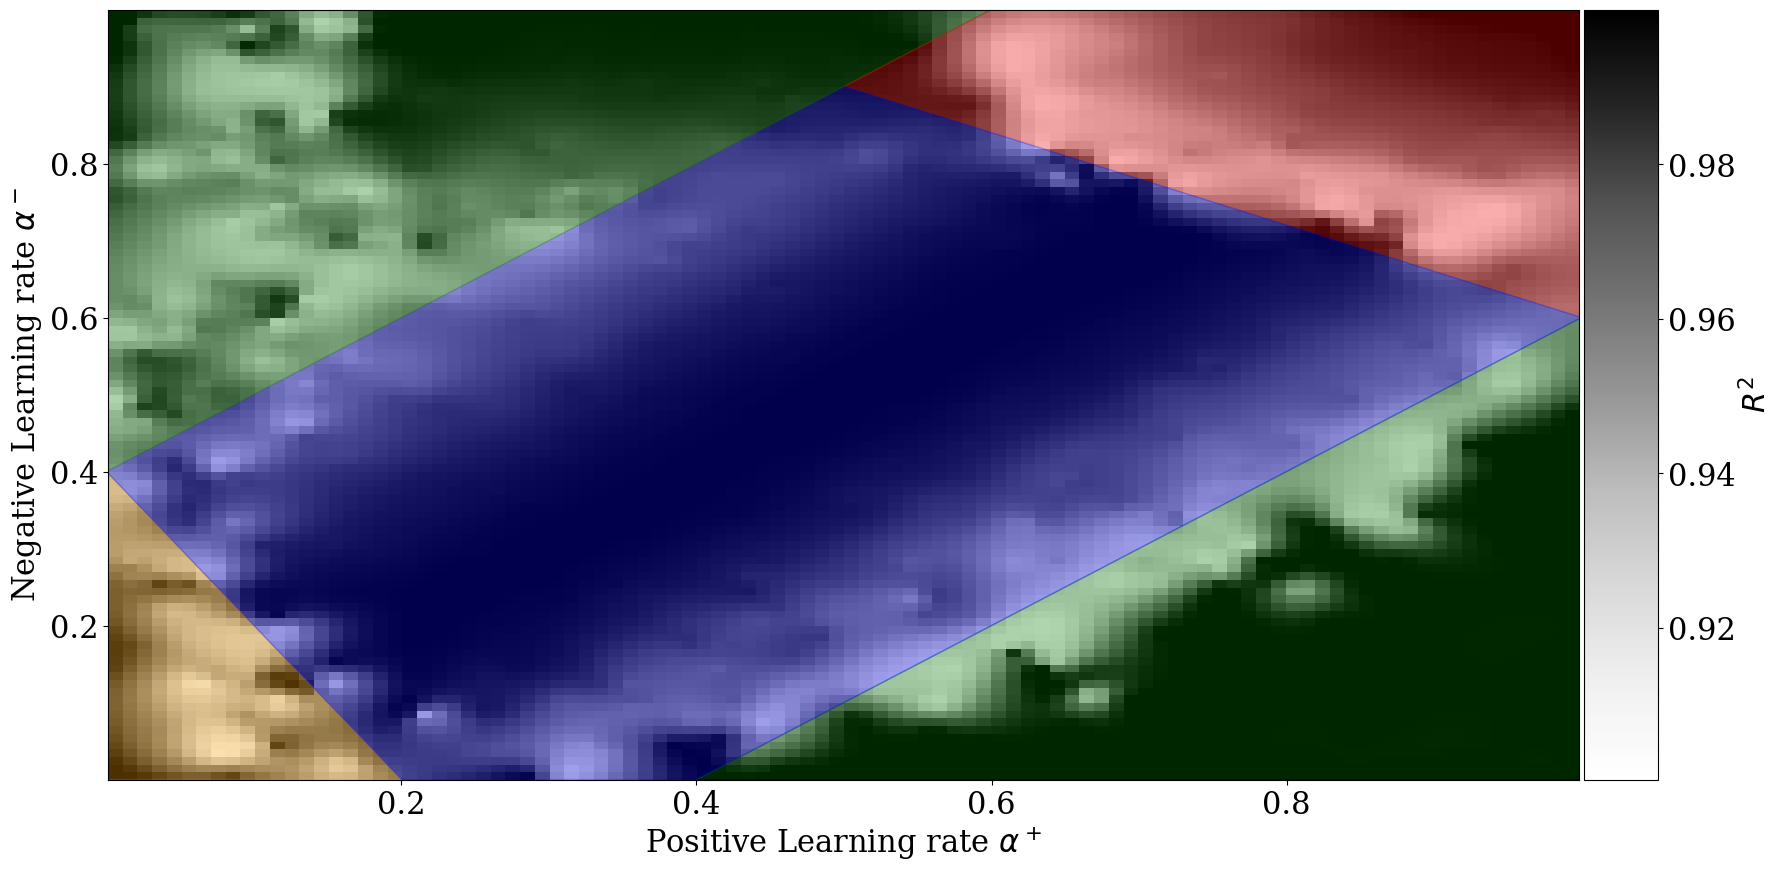

0.9822300580196619
0.9078415273680047
0.9999999798124549


In [10]:
data = pd.DataFrame(learning_asym_fixed_simdata)
fig = plt.figure()
ax2 = fig.add_subplot()
x=data['eta']
y=data['eta2']
z=data['r2']
# Set up a regular grid of interpolation points
xi, yi = np.linspace(np.min(x), np.max(x), 100), np.linspace(np.min(y), np.max(y), 100)
xi, yi = np.meshgrid(xi, yi)
# Interpolate
rbf = scipy.interpolate.Rbf(x, y, z, function='linear')
zi = rbf(xi, yi)
ax2.set_aspect("auto")
im2 = ax2.imshow(zi, vmin=np.min(z), vmax=np.max(z), origin='lower',
           extent=[np.min(x), np.max(x), np.min(y), np.max(y)], aspect='auto', cmap=cm.Greys)
ax2.set_xlabel(r'Positive Learning rate $\alpha^+$')
ax2.set_ylabel(r'Negative Learning rate $\alpha^-$')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label=r'$R^2$')
# plot colored areas to help visualize the boundaries between recovered models
ptslist = [np.array([[0,.4], [.6,1], [0,1]]),
           np.array([[.4,0], [1,.6], [1,0]]),
           np.array([[0,.4], [.2,0], [0,0]]),
           np.array([[1,.6], [1,1], [.6,1], [.5,.9]]),
           np.array([[0,.4], [.2,0], [.4,0], [1,.6], [.5,.9]]),
           ]
plist = [Polygon(ptslist[0], closed=False, alpha=.3, color='green'),
        Polygon(ptslist[1], closed=False, alpha=.3, color='green'),
        Polygon(ptslist[2], closed=False, alpha=.3, color='orange'),
        Polygon(ptslist[3], closed=False, alpha=.3, color='red'),
        Polygon(ptslist[4], closed=False, alpha=.3, color='blue'),
        ]
for x in plist:
    ax2.add_patch(x)
plt.show()
print(np.median(data['r2']))
print(np.percentile(data['r2'], 2.5))
print(np.percentile(data['r2'], 97.5))

## Step 5: Robustness to noise analyses
Run simulations for RW, RW + decay, and asym RW that perturb Q by some noise sampled from N(0, 0.05) on each trial. Vary the simulations with the number of trials completed by agents, ranging from 5 to 100 trials. In total, there are 600 simulations (3 models x 20 possible trial quantities x 10). Record the fits (R2) and recovered equations in dictionaries.

In [11]:
r2dict = {}
eqdict = {}
for mod in ['rw', 'decay', 'asym']:
    r2list = []
    eqlist = []
    sim_vallist = np.arange(0, 10, 1) # how many sims do you want to run of each trial size?
    sub_noiselist = np.arange(5, 105, 5) # cycle through the trial sizes
    for i, x in enumerate(sim_vallist):
        r2s = []
        eqs = []
        coefs = []
        for j, y in enumerate(sub_noiselist):
            if mod == 'rw':
                RLparams = {'subs': 100, # number of subjects for training data
                    'T': y, # number of trials per subject
                    'RW_function': standard_RW, # Rescoral-Wagner function
                    'q_noise': 0.05,
                    'eta_function': learning_fixed, # learning rate function
                    'eta_params': [.3], # parameters for learning rate function
                    'eta_noise': 0,
                    'beta_params': 1, # parameters for inverse temperature parameter of softmax (currently just fixed value)
                    'bandits': 1,
                    'mu0': 0.5,
                    'mu_behavior': 'random_walk_varying_intercept',
                    'reversal': None, # trial at which to reverse reward probabilities - set to None for no reversal
                    'seed': 101+x, # seed starting value - increases by 1 for each simulation
                    }
            elif mod == 'decay':
                RLparams = {'subs': 100, # number of subjects for training data
                    'T': y, # number of trials per subject
                    'RW_function': standard_RW, # Rescoral-Wagner function
                    'q_noise': 0.05,
                    'eta_function': learning_decay, # learning rate function
                    'eta_params': [10], # parameters for learning rate function
                    'eta_noise': 0,
                    'beta_params': 1, # parameters for inverse temperature parameter of softmax (currently just fixed value)
                    'bandits': 1,
                    'mu0': 0.5,
                    'mu_behavior': 'random_walk_varying_intercept',
                    'reversal': None, # trial at which to reverse reward probabilities - set to None for no reversal
                    'seed': 101+x, # seed starting value - increases by 1 for each simulation
                    }
            elif mod == 'asym':
                RLparams = {'subs': 100, # number of subjects for training data
                    'T': y, # number of trials per subject
                    'RW_function': standard_RW, # Rescoral-Wagner function
                    'q_noise': 0.05,
                    'eta_function': learning_asym_fixed, # learning rate function
                    'eta_params': [.8, .2], # parameters for learning rate function
                    'eta_noise': 0,
                    'beta_params': 1, # parameters for inverse temperature parameter of softmax (currently just fixed value)
                    'bandits': 1,
                    'mu0': 0.5,
                    'mu_behavior': 'random_walk_varying_intercept',
                    'reversal': None, # trial at which to reverse reward probabilities - set to None for no reversal
                    'seed': 101+x, # seed starting value - increases by 1 for each simulation
                    }
            qvals, qvalslist, X_test, control_inputs_training, control_inputs_testing, truevalslist, C, L = preSINDYsim(RLparams)
            generalized_library, feat_names = SINDYlibrary(qvals, 1)
            model, t, r2 = SINDYfit(generalized_library, feat_names, qvalslist, X_test, control_inputs_training, control_inputs_testing, RLparams, .9)
            if float(r2) < 0:
                r2 = 0
            r2s.append(float(r2))
            eqs.append(model.equations())
            print('Trials: %s; r2: %s; eq: %s' % (y, float(r2), model.equations()))
        r2list.append(r2s)
        eqlist.append(eqs)
    r2dict[mod] = r2list
    eqdict[mod] = eqlist

Trials: 5; r2: 0.5548094251079885; eq: ['-480.682 qvals[0][k] + 20016.391 rewards[k] + -56.288 time[k] + -0.053 qvals[0][k]^2 + 1.531 time[k]^2 + 0.046 qvals[0][k]*rewards[k] + 13.537 qvals[0][k]*time[k] + -318.407 rewards[k]*time[k] + 1.449 exp(-time[k]/30) + 0.776 exp(-time[k]/20) + -2.050 exp(-time[k]/10) + 134.208 qvals[0][k] exp(-time[k]/30) + -47254.101 rewards[k] exp(-time[k]/30) + 16.512 time[k] exp(-time[k]/30) + 520.905 qvals[0][k] exp(-time[k]/20) + 29343.608 rewards[k] exp(-time[k]/20) + 61.700 time[k] exp(-time[k]/20) + -174.069 qvals[0][k] exp(-time[k]/10) + -2105.652 rewards[k] exp(-time[k]/10) + -22.282 time[k] exp(-time[k]/10)']
Trials: 10; r2: 0.6800260725107679; eq: ['2075.475 qvals[0][k] + -1890.372 rewards[k] + -2614.812 time[k] + -0.022 qvals[0][k]^2 + 33.255 time[k]^2 + 0.025 qvals[0][k]*rewards[k] + -31.752 qvals[0][k]*time[k] + 28.819 rewards[k]*time[k] + 63767.549 exp(-time[k]/30) + 67470.897 exp(-time[k]/20) + -131238.508 exp(-time[k]/10) + -5108.139 qvals[0]

Next we plot the proportions of equations correctly recovered as a function of trial number, and the median R2 as a function of trial number. For the former, we are simply looking for the general form with identical terms, not the coefficient values scaling those terms. So long as SINDy recovered general form, we consider the equation correctly recovered.

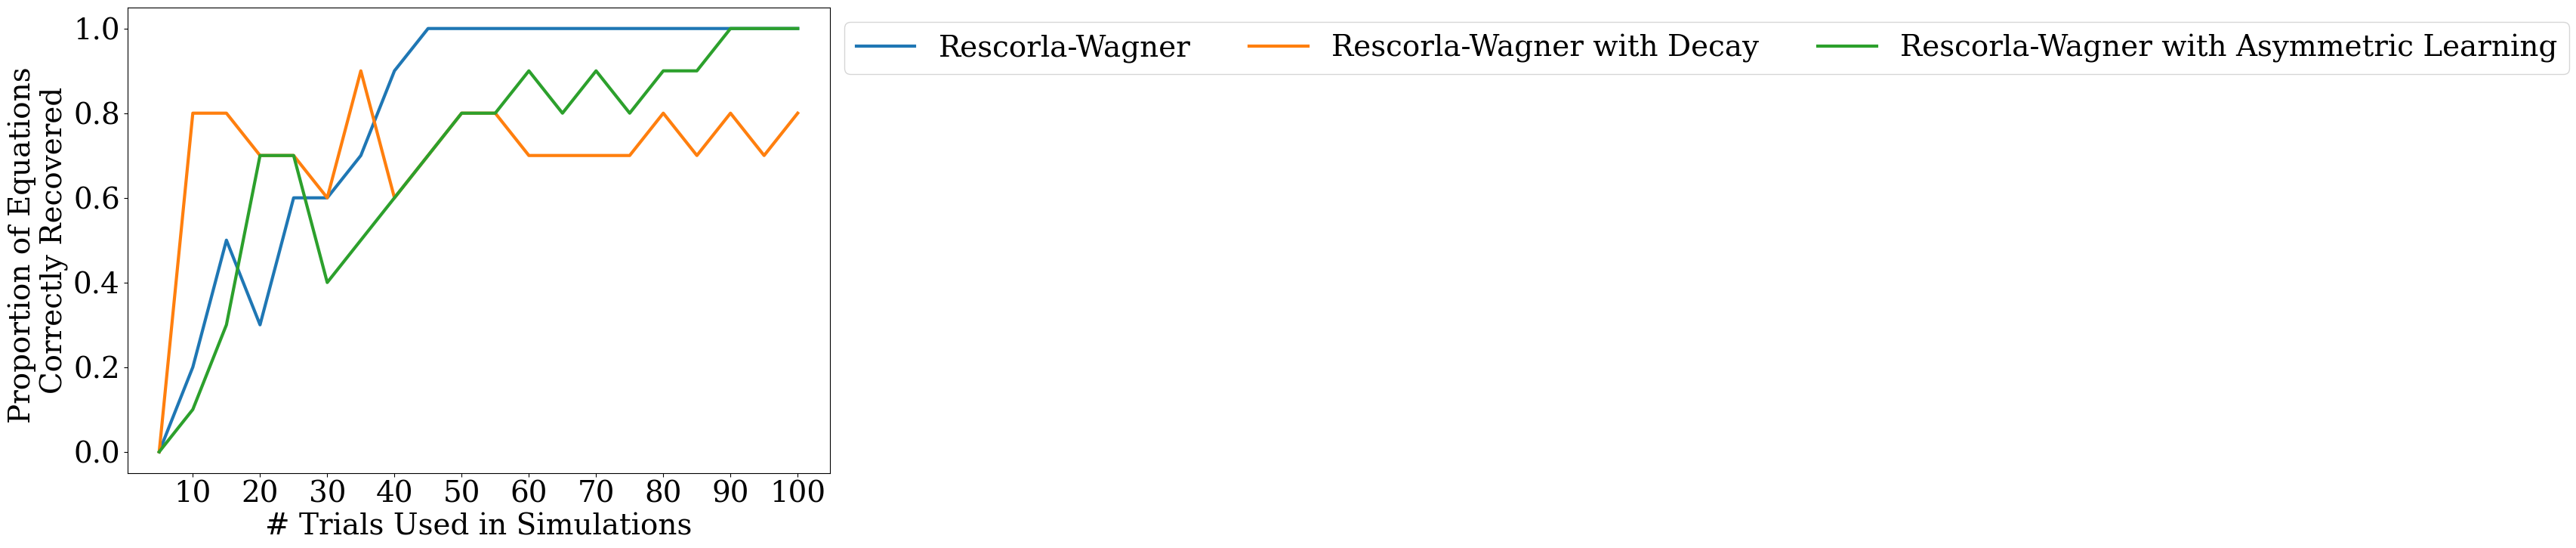

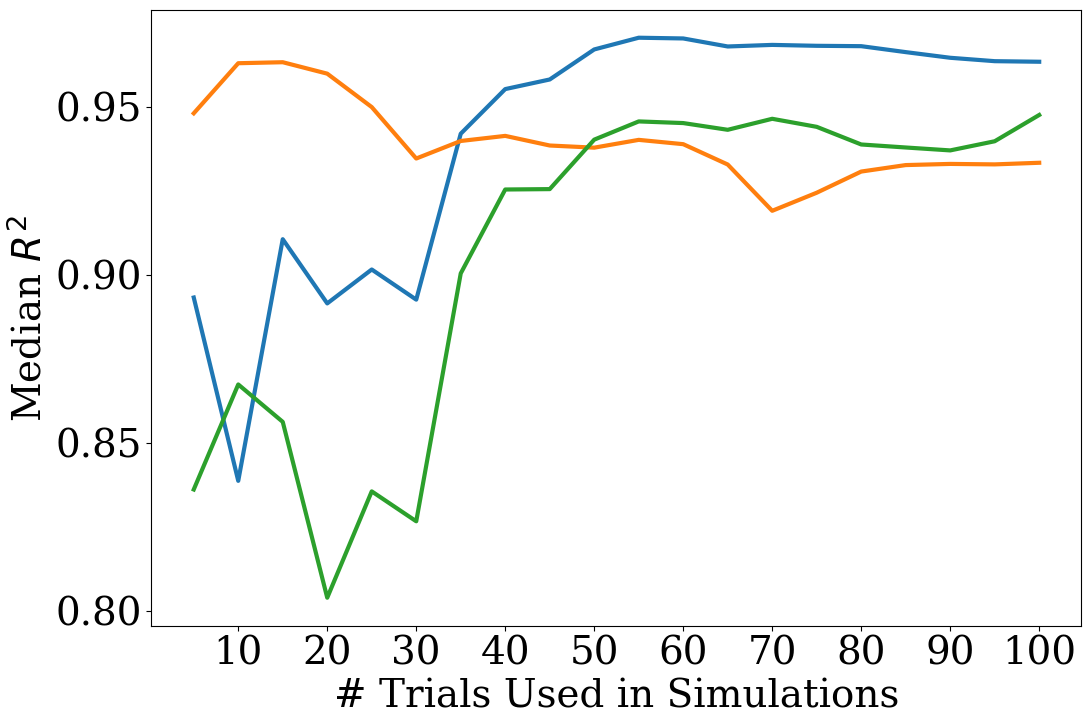

In [12]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 28}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (12, 8)

labellist = ['Rescorla-Wagner', 'Rescorla-Wagner with Decay', 'Rescorla-Wagner with Asymmetric Learning']
for m, mod in enumerate(['rw', 'decay', 'asym']):
    propslist = [0]*20
    for x in range(0, len(eqdict[mod])):
        for i, y in enumerate(eqdict[mod][x]):
            if mod == 'asym':
                if ' qvals[0][k] ' and ' rewards[k] ' and ' qvals[0][k]*rewards[k]' in y[0]:
                    if len(y[0]) < 75:
                        propslist[i] = propslist[i] + 1
            if mod == 'rw':
                if len(y[0]) > 34 and len(y[0]) <38 and ' qvals[0][k] ' in y[0] and ' rewards[k]' in y[0]:
                    propslist[i] = propslist[i] + 1
            if mod == 'decay':
                if len(y[0]) >89 and len(y[0]) <93:
                    propslist[i] = propslist[i] + 1
    fitlist = {'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': [],
            '10': [], '11': [], '12': [], '13': [], '14': [], '15': [], '16': [], '17': [], '18': [], '19': []}
    for x in range(0, len(r2dict[mod])):
        for i, y in enumerate(r2dict[mod][x]):
            fitlist[str(i)].append(y)
    medianfitlist = [np.median(fitlist[x]) for x in list(fitlist.keys())]
    if m == 0:
        noisedf = pd.DataFrame({'# Trials Used in Simulations': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
                                'Proportion of Equations \nCorrectly Recovered': [x/10 for x in propslist],
                                'Median $R^2$': medianfitlist,
                                'Model': [labellist[m]]*len(medianfitlist)})
    else:
        noisedf2 = pd.DataFrame({'# Trials Used in Simulations': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
                                'Proportion of Equations \nCorrectly Recovered': [x/10 for x in propslist],
                                'Median $R^2$': medianfitlist,
                                'Model': [labellist[m]]*len(medianfitlist)})
        noisedf = pd.concat([noisedf, noisedf2])
sns.lineplot(x='# Trials Used in Simulations', y='Proportion of Equations \nCorrectly Recovered', hue='Model', data=noisedf, linewidth=3)
plt.xticks([10,20,30,40,50,60,70,80,90,100])
plt.legend(bbox_to_anchor=(1, 1), ncol=3, title='')
plt.show()
sns.lineplot(x='# Trials Used in Simulations', y='Median $R^2$', hue='Model', data=noisedf, legend=False, linewidth=3)
plt.xticks([10,20,30,40,50,60,70,80,90,100])
plt.show()
